This builds on TESQ-ml-ns-nogo-go

> **proposal 1**
> 
> Two class (e.g., CorrectStop vs. CorrectGo)
> 
> Leave-One-Out classifier...
> 
> Neural similarity of a subject to the group with a Stop vs. Go contrast might actually be indicative of performance.
> 
> subjects will naturally differ across the task as to how much their average signal responds to that, and the ones with better response might have better response inhibition.

We use the same neural data, but instead of regressing on classifying these classes, we take one class or the other or we combine them in some way and we regress on our self report variables.

So there are a couple of steps here...

1. iterate through subjects, holding out one at a time, and do the following steps.
2. Train a regressor across all the training subjects, regressing CorrectStop and CorrectGo on TESQ-E and other self report measures including FFQ either (a) independently (b) contrasted with each other (c) concatenated in a single image.
3. If a link can be established, we've shown there is a relevant link between TESQ-E or other self-report measure, and the neural signature.
4. ...that seems like a publication in itself!




As a first pass, we can simplify this a bit just trying that single classifier on all subjects. This means that we're using train for tes tset but it will give us an initial measure of feasibility.

We probably do need to restrict to a specific brain region though, and that means retraining. - I think that prefrontal cortex mask we have works well.

## Data already generated

Can we use data already generated in `SST_inhibition_cv.ipynb`?

In [1]:
import pickle
from IPython.core.display import display, HTML, Markdown

/tmp/ipykernel_14189/659417397.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [2]:
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

In [3]:
#results_filepath=ml_data_folderpath + "/SST/train_test_results_conditions_40subs_twoclasses.pkl"

In [4]:
#results_2c = pickle.load(open(results_filepath,'rb'))

Not quite--we need a PFC mask I think. But we can use the script already written to do that.

## Setup

In [5]:
import sys
import os
import pandas as pd

sys.path.append(os.path.abspath("../../ml/"))

#from apply_loocv_and_save import *
#from dev_wtp_io_utils import *
import gc
import nibabel as nib

from os import path



In [6]:
from sklearn.svm import LinearSVC
from scipy.stats import ttest_1samp, pearsonr

In [7]:
from pymvpa2_ml_library import *
from generic_utils import *

In [8]:
from mvpa_pipeline_utils import get_Brain_Data_betas_as_mvpa_for_sub, import_beta_series_pymvpa2, sa_to_df

Failed to import duecredit due to No module named 'duecredit'
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/base.py:465: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, shape=None, sid=None, fid=None, dtype=np.float):


In [9]:
#from analyze_results import *

## condition_contrast

## stitching contrasts together in different ways

We'd want:

 - contrast of the two conditions
 - each of the two conditions alone.
 
The contrast is a little tricky. Easiest thing is to try each of the conditions alone. Stitching the two together might not be too hard. Let's try doing CorrectStop first, and then we'll try concatenating the images. Doing a contrast is actually the most difficult becuase I have to backtrack in the process to generate new betas (see https://docs.google.com/presentation/d/1K-nFrZYE6rR8t0myNyacB7frBzV3B1--nMqPhVkwL8E/edit#slide=id.geeff6890fb_0_16).

See `different ways of combining images.ipynb`.

## template

## regressing on self report

In [10]:
nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"
train_test_markers_filepath = ml_data_folderpath + "/train_test_markers_20210601T183243.csv"
test_train_df = pd.read_csv(train_test_markers_filepath)

all_sst_events= pd.read_csv(ml_data_folderpath +"/SST/" + "all_sst_events.csv")


script_path = '/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml'
# HRF 2s



In [11]:

## additional masks

all_masks = get_all_masks(ml_data_folderpath)

In [12]:
def setup_metadata(bd,target_val,standardize=True):
    #set up chunks and targets so we can do the learning.
    attribute_df = sa_to_df(bd.sa)
    pd.concat([attribute_df['subject'],attribute_df['wave']],axis=1)
    chunk = attribute_df['subject']+"_" + attribute_df['wave'].astype(str)
    bd.sa['chunks'] = list(chunk)
    if standardize:
        target_data = bd.sa[target_val].value
        target_data_mean = np.nanmean(target_data)
        target_data_std = np.nanstd(target_data)
        target_data_norm = (target_data-target_data_mean)/target_data_std
        bd.sa['targets'] = list(target_data_norm)
    else:
        bd.sa['targets'] = list(bd.sa[target_val].value)
    return(bd)

In [13]:
from sklearn.linear_model import Lasso
def do_Lasso(train_X,train_y,test_X,test_y):
    #if we fit intercept, it actually uses the y values to refit the items, 
    #adjusting everything up and down, and it can introduce _anticorrelation_ with the predicted value
    #may need to mean-center the predicted variable _before_ analysis.
    sklearn_regress = Lasso(alpha=2.0,fit_intercept=False)
    
    sklearn_regress.fit(train_X, train_y)
    
    predict_y = sklearn_regress.predict(test_X)
#    print(predict_y,test_y)
    return(predict_y,sklearn_regress)

In [14]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.svm import *
from sklearn.linear_model import *

def do_Ridge(train_X,train_y,test_X,test_y):
    sklearn_regress = Ridge(alpha=5.0)
    
    sklearn_regress.fit(train_X, train_y)
    
    predict_y = sklearn_regress.predict(test_X)
    return(predict_y,sklearn_regress)
    
def do_regression(dataset,normalization=None,get_prediction=None,verbose=False,require_mean_centered=True):
    if get_prediction is None:
        get_prediction = do_Ridge
    logo=LeaveOneGroupOut()

    group_scores = {}
    sample_wise_results = []

    items_to_eliminate_count = np.sum(np.isnan(dataset.sa.targets))
    items_total = len(dataset.sa.targets)
    print("eliminating " + str(items_to_eliminate_count) + " of " + 
          str(items_total) + " items due to null input values.")
    
    dataset=dataset[np.isnan(dataset.sa.targets)==False]
    
    #ensure data is standardized
    if abs(np.nanmean(dataset.sa.targets)>0.001) and require_mean_centered:
        raise Exception("target data is not mean-centred, but mean centering is required.")

    for train_index, test_index in logo.split(
        dataset.samples, dataset.sa.targets, dataset.sa.chunks):
        iteration_label = np.unique(dataset.sa.chunks[test_index])[0]

        #print(iteration_label, "; TRAIN:", len(train_index), " items; TEST:", test_index)
        print(".",end="",flush=True)

        #do train-test split
        train_X=dataset.samples[train_index]
        test_X = dataset.samples[test_index]
        train_y=dataset.sa.targets[train_index]
        test_y = dataset.sa.targets[test_index]
        #clf_svc = SVC()
        
        if normalization=="train_set_based":
            #get mean based on train set alone
            voxel_mean = np.mean(train_X,axis=0)
            voxel_sd = np.std(train_X,axis=0)
            #apply it to all.
            train_X=(train_X-voxel_mean)/voxel_sd
            test_X=(test_X-voxel_mean)/voxel_sd
            raise Exception("this is obsolete--think this method is completely wrong.")
            #print("normalizing")
#         print(train_y)
#         print(sum(np.isnan(train_y)))
#         print(test_y)
        predict_y, sklearn_clf = get_prediction(train_X,train_y,test_X,test_y)
        predict_y_train = sklearn_clf.predict(train_X)
#         print(pearsonr(predict_y_train,train_y))
#         print(predict_y)
#         print(predict_y_train)
        
        sample_wise_results_iter = pd.DataFrame({
            'chunks':[iteration_label]*len(test_y),
            'target_y':test_y,
            'pred_y':predict_y,
        })
            
        sample_wise_results = sample_wise_results + [sample_wise_results_iter]
        
    #need to create one more classifier to return.
    #we test and train on the same here, which is OK, because we don't use this to assess performance
    y_predict, model_final =get_prediction(
        dataset.samples,dataset.sa.targets,dataset.samples,dataset.sa.targets)
            
    sample_wise_results_df = pd.concat(sample_wise_results)
    return({'sample_wise':sample_wise_results_df,#'group_wise':group_scores,
            'model':model_final})


# Method fine-tuning

In [15]:
brain_data_filepath = ml_data_folderpath + '/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg.pkl'

In [16]:
ml_data_folderpath

'/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml'

In [17]:
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)


In [18]:
Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,'TESQ_E_sum')

In [19]:
np.unique(Brain_Data_allsubs.sa.condition_label)

array(['CorrectGoFollowingCorrectStop', 'CorrectGoFollowingFailedStop'],
      dtype='<U29')

In [20]:
Brain_Data_CorrectGoFollowingCorrectStop = Brain_Data_allsubs[Brain_Data_allsubs.sa.condition_label=='CorrectGoFollowingCorrectStop']

In [21]:
Brain_Data_CorrectGoFollowingFailedStop = Brain_Data_allsubs[Brain_Data_allsubs.sa.condition_label=='CorrectGoFollowingFailedStop']

In [22]:
from mvpa2.measures.rsa import Regression
from sklearn.linear_model import Ridge

In [23]:
regression_results = do_regression(Brain_Data_allsubs)

eliminating 12 of 162 items due to null input values.
...........................................................................

In [24]:
from sklearn.svm import LinearSVC
from scipy.stats import ttest_1samp, pearsonr, spearmanr

In [25]:
pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

(0.0742045878296486, 0.3668129918504953)

That's pretty good considering that we are regressing over all images whether they're Stop or Go signal. need to change this so that we alternately regress over stop or go only, or possibly, the difference between them.

The contrast between them is probably best, which means we go to generate a new series based on that.

Though, wait--why is it _negative_?

In [26]:
regression_results_CS = do_regression(Brain_Data_CorrectGoFollowingFailedStop)
pearsonr(regression_results_CS['sample_wise']['target_y'],regression_results_CS['sample_wise']['pred_y'])

eliminating 6 of 81 items due to null input values.
...........................................................................

(0.05564655686335038, 0.6353666837185526)

In [27]:
pearsonr(regression_results_CS['sample_wise']['target_y'],regression_results_CS['sample_wise']['pred_y'])

(0.05564655686335038, 0.6353666837185526)

In [28]:
regression_results_CS['sample_wise']

,chunks,target_y,pred_y
0,DEV005_1,-0.314867,0.511084
0,DEV006_1,1.328669,0.037375
0,DEV010_1,-0.747377,-0.757483
0,DEV011_1,-1.352890,-0.025431
0,DEV013_1,0.031141,0.180333
...,...,...,...
0,DEV197_1,0.550152,-0.071238
0,DEV206_1,-0.487871,-0.397298
0,DEV215_1,-0.833878,0.450203
0,DEV216_1,-1.093384,-0.793119


In [29]:
from matplotlib.pyplot import scatter

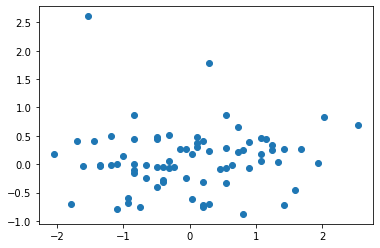

In [30]:
scatter(regression_results_CS['sample_wise']['target_y'],regression_results_CS['sample_wise']['pred_y'])

And really odd--why does it perform equally well for one class as for two? I thought two class analysis would be really nonsensical...which it is...considering the negative correlation for targets vs. pred

In [31]:
Brain_Data_CorrectGo = Brain_Data_allsubs[Brain_Data_allsubs.sa.condition_label=='CorrectGo']
regression_results_CG = do_regression(Brain_Data_CorrectGo)
pearsonr(regression_results_CG['sample_wise']['target_y'],regression_results_CG['sample_wise']['pred_y'])

eliminating 0 of 0 items due to null input values.


/tmp/ipykernel_19030/4091791375.py:32: RuntimeWarning: Mean of empty slice
  if abs(np.nanmean(dataset.sa.targets)>0.001) and require_mean_centered:


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

## try lasso

In [ ]:
regression_results = do_regression(Brain_Data_allsubs, get_prediction = do_Lasso)

In [ ]:
pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

In [ ]:
regression_results['sample_wise']['pred_y']

Yes OK, because there's no variance ther ebecause we have both stop and go there.

## stop minus go contrast

In [ ]:
brain_data_filepath = ml_data_folderpath + '/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_contrast.pkl'
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,'TESQ_E_sum')

In [ ]:
regression_results = do_regression(Brain_Data_allsubs,get_prediction = do_Ridge)
pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

In [ ]:
regression_results['sample_wise']['pred_y']

In [ ]:
regression_results['sample_wise']['target_y']

## Trial dummy data

We select a linear mix of voxels and try to predict that. should be easy to do with regression...

In [ ]:
brain_data_filepath = ml_data_folderpath + '/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_contrast.pkl'
#mvpa_Dataset_conditions_84subs_cor_stop_minus_go_contrast

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)


In [ ]:
mix_target = np.sum(Brain_Data_allsubs.samples[:,15000:15010],axis=1)
Brain_Data_allsubs.sa['mix_target']=list(mix_target)

In [ ]:

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,'mix_target')

regression_results = do_regression(Brain_Data_allsubs, get_prediction = do_Ridge)

pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

That's interesting--something like it should be, but not very good considering.

In [ ]:
mix_target = np.sum(Brain_Data_allsubs.samples[:,15000:15100],axis=1)
Brain_Data_allsubs.sa['mix_target']=list(mix_target)
Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,'mix_target')
regression_results = do_regression(Brain_Data_allsubs, get_prediction = do_Ridge)
pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

aahhh got it--if the pattern is spread over several voxels, we'll have a better time detecting it.

In [ ]:
mix_target = np.sum(Brain_Data_allsubs.samples[:,15000:15100],axis=1)
Brain_Data_allsubs.sa['mix_target']=list(mix_target)

In [ ]:
scatter(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

OK, so if there's a pattern representing a linear combination of voxels then we should be able to detect it using ridge regression. How about lasso?

In [ ]:
from sklearn.linear_model import Lasso
def do_Lasso(train_X,train_y,test_X,test_y):
    #if we fit intercept, it actually uses the y values to refit the items, 
    #adjusting everything up and down, and it can introduce _anticorrelation_ with the predicted value
    #may need to mean-center the predicted variable _before_ analysis.
    sklearn_regress = Lasso(alpha=1.0,fit_intercept=False)
    
    sklearn_regress.fit(train_X, train_y)
    
    predict_y = sklearn_regress.predict(test_X)
#    print(predict_y,test_y)
    return(predict_y,sklearn_regress)

In [ ]:
regression_results = do_regression(Brain_Data_allsubs, get_prediction = do_Lasso)
print(pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y']))
scatter(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

In [ ]:
from sklearn.linear_model import Lasso
def do_Lasso2(train_X,train_y,test_X,test_y):
    #if we fit intercept, it actually uses the y values to refit the items, 
    #adjusting everything up and down, and it can introduce _anticorrelation_ with the predicted value
    #may need to mean-center the predicted variable _before_ analysis.
    sklearn_regress = Lasso(alpha=1.0,fit_intercept=True)
    
    sklearn_regress.fit(train_X, train_y)
    
    predict_y = sklearn_regress.predict(test_X)
#    print(predict_y,test_y)
    return(predict_y,sklearn_regress)

In [ ]:
regression_results = do_regression(Brain_Data_allsubs, get_prediction = do_Lasso2)
print(pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y']))
scatter(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

In [ ]:
mix_target = np.sum(Brain_Data_allsubs.samples[:,15000:15100],axis=1)
Brain_Data_allsubs.sa['mix_target']=list(mix_target)
Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,'mix_target',standardize=False)
regression_results = do_regression(Brain_Data_allsubs, get_prediction = do_Lasso2, require_mean_centered=False)
pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

In [ ]:
regression_results = do_regression(Brain_Data_allsubs, get_prediction = do_Lasso2)
print(pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y']))
scatter(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

In [ ]:
regression_results = do_regression(Brain_Data_allsubs, get_prediction = do_Lasso)
print(pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y']))
scatter(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

In [ ]:
pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

So in summary--we can't predict TESQ-E-Sum using Ridge or Lasso regression. Because prediction is `greedy' in a sense--it'll take voxels anywhere in the image and emphasize them until they're useful--there's no point in trying different masks. We might try different scales, bu there's no use in doing a regression on masks.

#### Elastic net?

In [ ]:
from sklearn.linear_model import ElasticNet
def do_ElasticNet(train_X,train_y,test_X,test_y):
    sklearn_regress = ElasticNet(alpha=10.0,fit_intercept=False)
    
    sklearn_regress.fit(train_X, train_y)
    
    predict_y = sklearn_regress.predict(test_X)
    return(predict_y,sklearn_regress)

In [ ]:

elastic_regression_results = do_regression(Brain_Data_allsubs, get_prediction = do_ElasticNet)


In [ ]:

scatter(elastic_regression_results['sample_wise']['target_y'],elastic_regression_results['sample_wise']['pred_y'])
pearsonr(elastic_regression_results['sample_wise']['target_y'],elastic_regression_results['sample_wise']['pred_y'])

OK, of the three (Ridge, Elastic, Lasso), Lasso performs best on the dummy data, so we'll use that.

## PCA?

# Main analysis: Cycle through relevant variables...

We'll cycle through:

 - TESQ-E subscales
 - BF%
 - SSRT

### Stop Minus Go

In [26]:
", ".join(sa_to_df(Brain_Data_allsubs.sa).columns)

'time_indices, time_coords, condition_index, condition_label, raw_beta_description, beta, subject, wave, cancer_promoting_minus_preventing_FCI, cancer_promoting_minus_preventing_FFQ, cancer_promoting_minus_preventing_craved_FCI, cancer_promoting_minus_preventing_craved_FFQ, cancer_promoting_minus_preventing_liked_FCI, cancer_promoting_minus_preventing_liked_FFQ, cancer_promoting_FCI, cancer_promoting_FFQ, cancer_preventing_FCI, cancer_preventing_FFQ, BSCS, cSES, EDM, BIS_11, PCS, RS, TRSQ, bf_1, weight_0, height_0, birthsex, age365, bmi_0, bmi_1, bmi, bf_1_controlled, bf_1_bsexnormedzs, ACES_sum, ACES_household_dysfunction, ACES_neglectful_parenting, ACES_abuse, ACES_divorced_separated, BFI_agreeableness, BFI_conscientiousness, BFI_extraversion, BFI_neuroticism, BFI_openness, DEMO_mcarthur_social_standing, IMI_effort_importance, IMI_interest_enjoyment, IMI_perceived_choice, IMI_perceived_competence, IMI_value_usefulness, IPAQ_moderateminutes, IPAQ_sittinghours, IPAQ_vigorousminutes, IP

In [27]:
brain_data_filepath = ml_data_folderpath + '/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_contrast.pkl'
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,'FFQ_v2_Mean_Weighted_Nutrient_Density')

regression_results = do_regression(Brain_Data_allsubs,do_Lasso)
pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

eliminating 8 of 81 items due to null input values.
.........................................................................

(-0.22230173762044284, 0.05871900289544976)

In [28]:
brain_data_filepath = ml_data_folderpath + '/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_contrast.pkl'
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)



In [29]:
regression_results_dict = {}
for regression_var in [
    'FFQ_v2_Mean_Weighted_Nutrient_Density',
    'SST_pes_mean_limited',
    'SST_PostErrorSlowW1_mean',
    'RTFS_factor_1',
    'RTFS_factor_2','RTFS_f1_minus_f2'
                      ]:
    print(regression_var)
    Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,regression_var)
    regression_results = do_regression(Brain_Data_allsubs, get_prediction = do_Lasso)
    regression_results_dict[regression_var] = regression_results
    print(pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y']))
    print("---")

FFQ_v2_Mean_Weighted_Nutrient_Density
eliminating 8 of 81 items due to null input values.
.........................................................................(-0.1432150784222959, 0.2267577179364377)
---
SST_pes_mean_limited
eliminating 15 of 81 items due to null input values.
..................................................................(-0.09079193424666142, 0.46844986440702807)
---
SST_PostErrorSlowW1_mean
eliminating 16 of 81 items due to null input values.
.................................................................(0.16705888041230982, 0.18348299519293643)
---
RTFS_factor_1
eliminating 30 of 81 items due to null input values.
...................................................(0.04786458620847692, 0.7387277441848147)
---
RTFS_factor_2
eliminating 30 of 81 items due to null input values.
...................................................(0.22507741662535566, 0.11229162427140402)
---
RTFS_f1_minus_f2
eliminating 32 of 81 items due to null input values.
..............

No signficant results here.

### two conditions separately

In [36]:
brain_data_filepath = ml_data_folderpath + '/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg.pkl'
#mvpa_Dataset_conditions_84subs_cor_stop_minus_go_contrast

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)


In [37]:
Brain_Data_CorrectGoFollowingCorrectStop = Brain_Data_allsubs[Brain_Data_allsubs.sa.condition_label=='CorrectGoFollowingCorrectStop']
Brain_Data_CorrectGoFollowingFailedStop = Brain_Data_allsubs[Brain_Data_allsubs.sa.condition_label=='CorrectGoFollowingFailedStop']

In [38]:
def do_Ridge(train_X,train_y,test_X,test_y):
    sklearn_regress = Ridge(alpha=2.0)
    
    sklearn_regress.fit(train_X, train_y)
    
    predict_y = sklearn_regress.predict(test_X)
    return(predict_y,sklearn_regress)

In [39]:
for bd in [Brain_Data_CorrectGoFollowingCorrectStop, Brain_Data_CorrectGoFollowingFailedStop]:
    print(np.unique(bd.sa.condition_label))
    for regression_var in [
    'FFQ_v2_Mean_Weighted_Nutrient_Density',
    'SST_pes_mean_limited',
    'SST_PostErrorSlowW1_mean',
    'RTFS_factor_1',
    'RTFS_factor_2',
        'RTFS_f1_minus_f2'
                          ]:
        print(regression_var)
        
        bd = setup_metadata(bd,regression_var)
        regression_results = do_regression(bd, get_prediction = do_Lasso)
        regression_results_dict[regression_var] = regression_results
        print(pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y']))
        print("---")

['CorrectGoFollowingCorrectStop']
FFQ_v2_Mean_Weighted_Nutrient_Density
eliminating 8 of 81 items due to null input values.
.........................................................................(-0.30011621879321265, 0.009888657989672912)
---
SST_pes_mean_limited
eliminating 15 of 81 items due to null input values.
..................................................................(nan, nan)
---
SST_PostErrorSlowW1_mean
eliminating 16 of 81 items due to null input values.
.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


................................................................(0.05323298519018589, 0.6736459649612041)
---
RTFS_factor_1
eliminating 30 of 81 items due to null input values.
...................................................(-0.45607727688272515, 0.0007695946729048088)
---
RTFS_factor_2
eliminating 30 of 81 items due to null input values.
...................................................(0.2623669722447763, 0.06289194320407067)
---
RTFS_f1_minus_f2
eliminating 32 of 81 items due to null input values.
.................................................(-0.04979495235856285, 0.7340242673822558)
---
['CorrectGoFollowingFailedStop']
FFQ_v2_Mean_Weighted_Nutrient_Density
eliminating 8 of 81 items due to null input values.
.........................................................................(-0.3480589314735139, 0.0025491622451461766)
---
SST_pes_mean_limited
eliminating 15 of 81 items due to null input values.
..................................................................(-0.147

Predictions passing the threshold of r>=0.25:
    
 - RTFS_factor_2 * CorrectGoFollowingCorrectStop


In [40]:
regression_results['sample_wise'].target_y.mean()

-3.6252180395923476e-17

In [41]:
bd.sa.targets

array([        nan,         nan,         nan,         nan,  2.01547744,
               nan,         nan,         nan, -2.33438633,  0.77265922,
               nan,         nan,  0.42467012,         nan,         nan,
       -0.470159  ,         nan, -1.26556266,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
       -0.04760081,         nan,  0.82237195,         nan,         nan,
       -0.84300447,         nan, -1.83725905,  1.59291924,  1.06070062,
               nan, -0.53117008, -0.79329174, -1.21224756, -1.19099357,
       -0.81814811,  1.09579195,  0.05182465, -0.24844555, -0.76843538,
        0.37495739,  0.94665377,         nan,  0.27553193, -0.24645172,
        0.16028878,         nan,  0.69809012, -2.02616742,  0.15125011,
       -0.84300447,  0.79751558,  0.49923921,  0.59866467,         nan,
       -0.59444083,         nan, -0.53407537,  0.25067556,  0.20096284,
        0.82237195, -1.51412631,  0.69809012,  0.58091012, -0.12

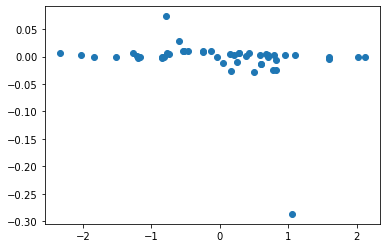

In [42]:
from matplotlib.pyplot import scatter
scatter(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

In [43]:
pearsonr(regression_results['sample_wise']['target_y'],regression_results['sample_wise']['pred_y'])

(-0.23567550913462623, 0.10306033862920526)

In [44]:
print('finishsed')

finishsed


## Correct STop and Correct Go spatially concatenated